# TP Analyse d'images médicales - Daniel / Gattino

#### Import

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Concatenate, Flatten, Dense

#### Data preparation

In [11]:
# Chemins vers les dossiers contenant les images
data_dir = 'Brain-Tumor-Classification-DataSet-master/Training/'

# Paramètres
img_height, img_width = 256, 256
batch_size = 32

# Utilisation de ImageDataGenerator pour la génération des données avec augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# Générateur de données d'entraînement
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

# Générateur de données de validation
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)
#categorical
#binary

Found 2585 images belonging to 4 classes.
Found 285 images belonging to 4 classes.


#### Model Unet

In [5]:
def unet_model(input_size=(256, 256, 1), num_classes=4):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    
    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = Concatenate()([conv3, up5])
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = Concatenate()([conv2, up6])
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = Concatenate()([conv1, up7])
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)
    
    flatten = Flatten()(conv7)
    dense1 = Dense(128, activation='relu')(flatten)
    dense2 = Dense(num_classes, activation='softmax')(dense1)
    
    model = Model(inputs, dense2)
    
    model.compile(optimizer=Adam(lr=1e-4), loss=CategoricalCrossentropy(), metrics=[Accuracy()])
    
    return model
 
# Création du modèle
model = unet_model(input_size=(256, 256, 1), num_classes=4)
 
# Afficher le résumé du modèle
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

#### Training

In [6]:
# Entraînement du modèle
history = model.fit(train_generator, validation_data=(validation_generator), epochs=20, batch_size=16)


Epoch 1/20
144/144 [==============================] - 1106s 8s/step - loss: 0.4485 - accuracy: 0.8583 - val_loss: 0.3648 - val_accuracy: 0.8780
Epoch 2/20
144/144 [==============================] - 1036s 7s/step - loss: 0.4087 - accuracy: 0.8584 - val_loss: 0.3596 - val_accuracy: 0.8780
Epoch 3/20
144/144 [==============================] - 1003s 7s/step - loss: 0.3996 - accuracy: 0.8584 - val_loss: 0.3465 - val_accuracy: 0.8791
Epoch 4/20
144/144 [==============================] - 1020s 7s/step - loss: 0.3963 - accuracy: 0.8595 - val_loss: 0.3414 - val_accuracy: 0.8789
Epoch 5/20
144/144 [==============================] - 1013s 7s/step - loss: 0.3798 - accuracy: 0.8597 - val_loss: 0.3561 - val_accuracy: 0.8776
Epoch 6/20
144/144 [==============================] - 981s 7s/step - loss: 0.3655 - accuracy: 0.8648 - val_loss: 0.3179 - val_accuracy: 0.8840
Epoch 7/20
144/144 [==============================] - 1038s 7s/step - loss: 0.3571 - accuracy: 0.8694 - val_loss: 0.3428 - val_accuracy: 

#### Model Evaluation

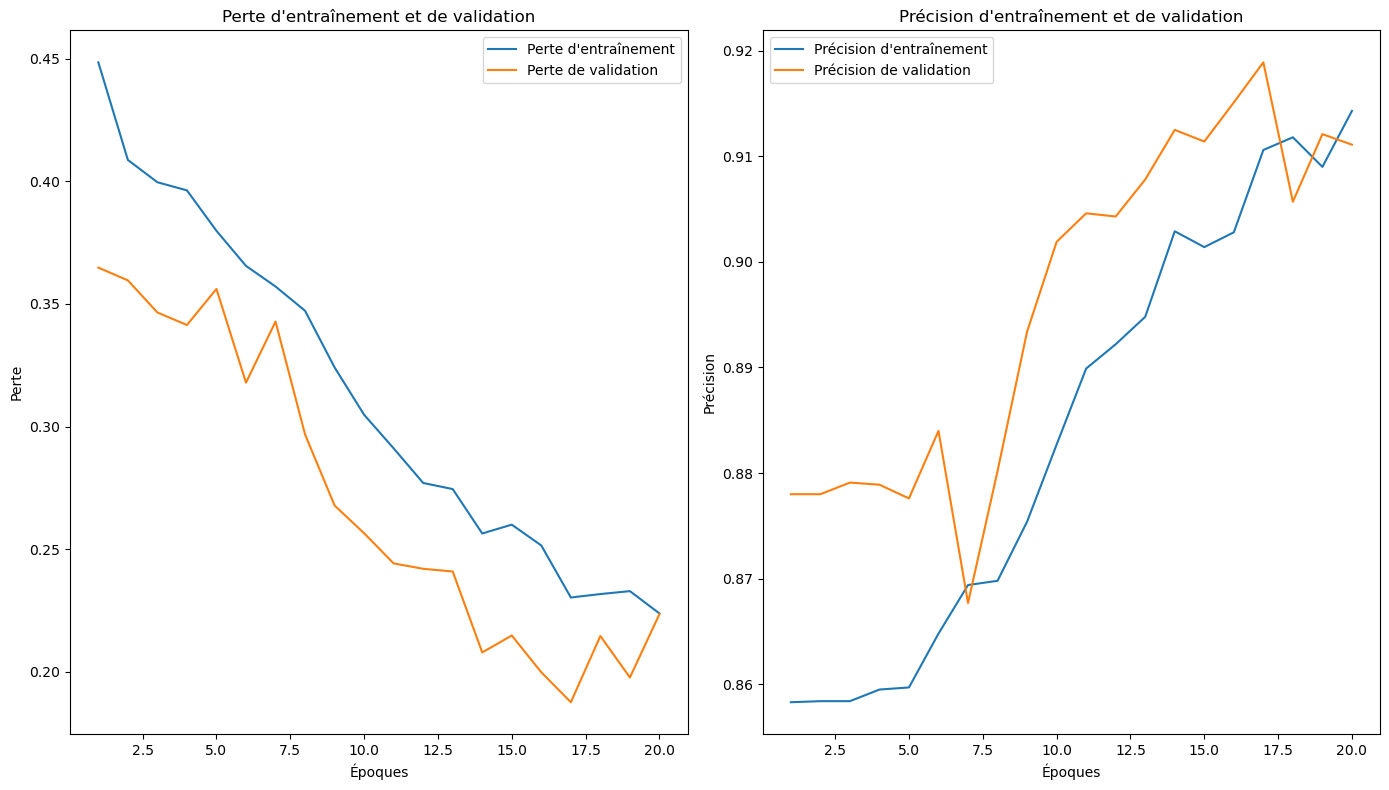

In [1]:
# Graphique d'évaluation de performance

epochs = list(range(1, 21))
loss = model.history.history['loss']
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']

# Tracer le graphique
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Perte d\'entraînement')
plt.plot(epochs, val_loss, label='Perte de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Perte d\'entraînement et de validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Précision d\'entraînement')
plt.plot(epochs, val_accuracy, label='Précision de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.title('Précision d\'entraînement et de validation')
plt.legend()

plt.tight_layout()
plt.show()


#### Deployment and Testing

In [9]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# Liste des classes
class_names = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(256, 256), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)  # Prédiction multi-classes
    return class_names[predicted_class[0]]

def evaluate_on_test_set(test_dir):
    y_true = []
    y_pred = []

    for class_name in class_names:
        class_dir = os.path.join(test_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            predicted_label = predict_image(img_path)
            true_label = class_name
            y_true.append(true_label)
            y_pred.append(predicted_label)

    # Calcul de l'accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")

# Exécuter l'évaluation sur le dossier de test
test_dir = 'Brain-Tumor-Classification-DataSet-master/Testing'
evaluate_on_test_set(test_dir)


1/1 [==============================] - 0s 96ms/step
Accuracy: 0.75


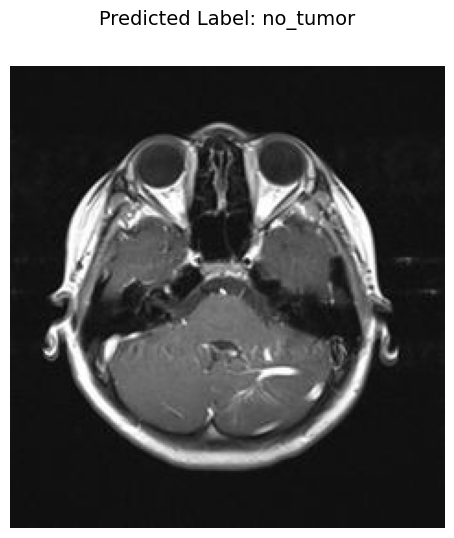

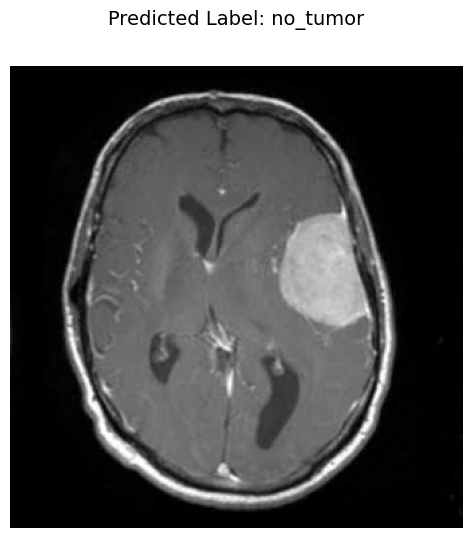

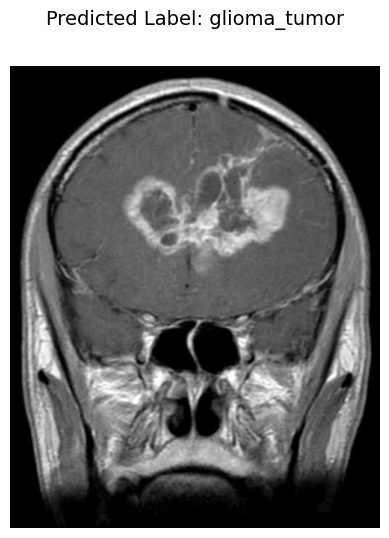

In [5]:
def evaluate_on_specific_image(image_path, model):
    predicted_label = predict_image(image_path, model)
    print(f"Predicted Label: {predicted_label}")

image_path = 'Brain-Tumor-Classification-DataSet-master/Testing/no_tumor/image.jpg'  # Replace with your image path
# Load your trained model into the 'model' variable before calling evaluate_on_specific_image

# Assuming 'model' is loaded with your trained model
evaluate_on_test_set(image_path, model)

image_path = 'Brain-Tumor-Classification-DataSet-master/Testing/meningioma_tumor/image.jpg'  # Replace with your image path
# Load your trained model into the 'model' variable before calling evaluate_on_specific_image

# Assuming 'model' is loaded with your trained model
evaluate_on_test_set(image_path, model)

image_path = 'Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor/image.jpg'  # Replace with your image path
# Load your trained model into the 'model' variable before calling evaluate_on_specific_image

# Assuming 'model' is loaded with your trained model
evaluate_on_test_set(image_path, model)